# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "DAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'DAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                     
Sample_014  Q9NY97;Q9NY97-2                       16.504
Sample_024  B5MBX2;F8WE86;P20062;P20062-2         18.163
Sample_072  Q99985                                14.952
Sample_169  Q15375;Q15375-4                       15.037
Sample_058  A0A0C4DH07;Q8N2S1;Q8N2S1-2;Q8N2S1-3   17.308
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by DAE: runs/alzheimer_study/preds/pred_real_na_DAE.csv


Sample ID   protein groups                                      
Sample_054  Q9UI40;Q9UI40-2                                        14.386
Sample_198  J3KSJ8;Q9UD71;Q9UD71-2                                 11.329
Sample_111  K7EIS2;K7EKV3;K7EM70;K7EQL9;Q9BSG5;Q9BSG5-2;Q9BSG5-3   13.604
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.746
            A0A075B6Q5                 12.668
            A0A075B6R2                 12.219
            A0A075B6S5                 13.019
            A0A087WSY4                 12.829
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.638
            Q9UI40;Q9UI40-2            11.588
            Q9UIW2                     12.473
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.043
            Q9UP79                     12.259
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.395,15.050,16.842,19.863,16.076,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.737,19.067,...,15.528,15.576,14.019,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.963,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.952,17.705,17.039,15.395,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.319,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.298,15.345,17.084,18.708,14.249,19.433,11.643,10.763
Sample_207,15.739,16.877,15.469,16.898,13.912,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,12.770,12.646,13.588,14.025,12.864,12.934,13.749,12.908,13.721,12.400
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.424,19.067,16.127,...,13.887,12.339,12.596,11.982,14.071,13.605,12.971,12.220,13.866,12.270
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,11.777,12.434,11.975,13.326,12.123,12.108,12.988,13.212,12.413,13.141
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.042,13.065,13.220,12.969,12.314,13.536,13.583,14.433,12.156,12.622
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.363,12.705,13.151,13.174,11.822,13.006,14.459,12.344,13.158,13.689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,13.236,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 337.90it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

100%|██████████| 2/2 [00:00<00:00,  4.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  8.37it/s]

100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

100%|██████████| 3/3 [00:00<00:00,  6.06it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.52it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.78it/s]

100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

100%|██████████| 4/4 [00:01<00:00,  3.22it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.11it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.51it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.26it/s]

100%|██████████| 5/5 [00:01<00:00,  3.35it/s]

100%|██████████| 5/5 [00:01<00:00,  3.50it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.48it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.23it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.16it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.01it/s]

100%|██████████| 6/6 [00:01<00:00,  3.93it/s]

100%|██████████| 6/6 [00:01<00:00,  4.31it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.02it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.51it/s]

 57%|█████▋    | 4/7 [00:01<00:00,  3.42it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.65it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.33it/s]

100%|██████████| 7/7 [00:02<00:00,  3.32it/s]

100%|██████████| 7/7 [00:02<00:00,  3.49it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.57it/s]

 38%|███▊      | 3/8 [00:01<00:02,  2.46it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.25it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.37it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.62it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.61it/s]

100%|██████████| 8/8 [00:03<00:00,  2.60it/s]

100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.23it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.24it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.16it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.11it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.16it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.21it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.18it/s]

100%|██████████| 9/9 [00:02<00:00,  2.88it/s]

100%|██████████| 9/9 [00:02<00:00,  3.11it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.20it/s]

 30%|███       | 3/10 [00:00<00:01,  4.82it/s]

 40%|████      | 4/10 [00:00<00:01,  4.15it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.94it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.92it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.00it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.12it/s]

 90%|█████████ | 9/10 [00:02<00:00,  4.19it/s]

100%|██████████| 10/10 [00:02<00:00,  4.10it/s]

100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.77it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.55it/s]

 36%|███▋      | 4/11 [00:00<00:01,  5.18it/s]

 45%|████▌     | 5/11 [00:00<00:01,  4.98it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.78it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.64it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.05it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.09it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.92it/s]

100%|██████████| 11/11 [00:02<00:00,  4.08it/s]

100%|██████████| 11/11 [00:02<00:00,  4.49it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.12it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.01it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.22it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.67it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.32it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.18it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.31it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.29it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.24it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.18it/s]

100%|██████████| 12/12 [00:02<00:00,  4.23it/s]

100%|██████████| 12/12 [00:02<00:00,  4.53it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  9.70it/s]

 23%|██▎       | 3/13 [00:00<00:01,  7.18it/s]

 31%|███       | 4/13 [00:00<00:01,  5.86it/s]

 38%|███▊      | 5/13 [00:00<00:01,  4.83it/s]

 46%|████▌     | 6/13 [00:01<00:01,  4.17it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  4.05it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  4.05it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  4.11it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.16it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  4.23it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  4.27it/s]

100%|██████████| 13/13 [00:02<00:00,  4.24it/s]

100%|██████████| 13/13 [00:02<00:00,  4.52it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.78it/s]

 21%|██▏       | 3/14 [00:00<00:01,  5.81it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.97it/s]

 36%|███▌      | 5/14 [00:00<00:01,  4.61it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.17it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.66it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.68it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.65it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.86it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  3.97it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.95it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.05it/s]

100%|██████████| 14/14 [00:03<00:00,  3.88it/s]

100%|██████████| 14/14 [00:03<00:00,  4.13it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.72it/s]

 20%|██        | 3/15 [00:00<00:02,  5.57it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.63it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.57it/s]

 40%|████      | 6/15 [00:01<00:02,  3.70it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.75it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  3.65it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.86it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.74it/s]

 73%|███████▎  | 11/15 [00:02<00:01,  3.92it/s]

 80%|████████  | 12/15 [00:02<00:00,  3.82it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.91it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.95it/s]

100%|██████████| 15/15 [00:03<00:00,  4.00it/s]

100%|██████████| 15/15 [00:03<00:00,  4.07it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.017          0.821 0.295       0.130   
2             0.004 0.002      0.053 0.020          0.626 0.131       0.527   
3             0.005 0.002      0.059 0.024          0.684 0.102       0.649   
4             0.003 0.001      0.039 0.006          0.688 0.112       0.637   
5             0.005 0.002      0.055 0.021          0.748 0.094       0.705   
6             0.005 0.003      0.056 0.023          0.749 0.094       0.718   
7             0.003 0.000      0.036 0.001          0.745 0.092       0.720   
8             0.006 0.004      0.062 0.030          0.786 0.083       0.806   
9             0.006 0.004      0.060 0.030          0.796 0.086       0.819   
10            0.003 0.001      0.028 0.012          0.853 0.080       0.815   
11            0.004 0.001      0.040 0.009          0.828 0.085       0.827   
12            0.004 0.001      0.040 0.010          0.819 0.087       0.824   
13            0.004 0.001      0.039 0.005          0.818 0.091       0.821   
14            0.004 0.001      0.039 0.005          0.824 0.089       0.818   
15            0.004 0.002      0.041 0.009          0.815 0.096       0.809   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.083   0.217 0.124                  0.558 0.040        0.850   
2          0.144   0.560 0.115                  0.643 0.079        0.725   
3          0.136   0.659 0.101                  0.713 0.076        0.789   
4          0.149   0.653 0.110                  0.711 0.080        0.786   
5          0.095   0.721 0.072                  0.763 0.060        0.833   
6          0.104   0.728 0.078                  0.768 0.064        0.834   
7          0.102   0.727 0.076                  0.768 0.062        0.830   
8          0.106   0.790 0.070                  0.820 0.059        0.901   
9          0.100   0.803 0.069                  0.831 0.059        0.901   
10         0.114   0.829 0.080                  0.855 0.067        0.919   
11         0.100   0.825 0.078                  0.850 0.067        0.919   
12         0.105   0.818 0.080                  0.845 0.069        0.917   
13         0.108   0.815 0.079                  0.842 0.069        0.915   
14         0.106   0.817 0.078                  0.844 0.067        0.911   
15         0.112   0.807 0.083                  0.836 0.071        0.912   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.821 0.086        210.000 0.000  
2          0.081                  0.671 0.094        210.000 0.000  
3          0.074                  0.737 0.101        210.000 0.000  
4          0.076                  0.733 0.103        210.000 0.000  
5          0.067                  0.806 0.079        210.000 0.000  
6          0.066                  0.803 0.084        210.000 0.000  
7          0.066                  0.798 0.085        210.000 0.000  
8          0.049                  0.874 0.061        210.000 0.000  
9          0.048                  0.878 0.057        210.000 0.000  
10         0.048                  0.904 0.053        210.000 0.000  
11         0.050                  0.907 0.055        210.000 0.000  
12         0.051                  0.904 0.055        210.000 0.000  
13         0.051                  0.899 0.058        210.000 0.000  
14         0.050                  0.891 0.057        210.000 0.000  
15         0.051                  0.894 0.057 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 542.88it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  7.01it/s]

100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.06it/s]

100%|██████████| 3/3 [00:00<00:00,  4.47it/s]

100%|██████████| 3/3 [00:00<00:00,  4.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.10it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.06it/s]

100%|██████████| 4/4 [00:00<00:00,  4.24it/s]

100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.72it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.09it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.45it/s]

100%|██████████| 5/5 [00:01<00:00,  3.34it/s]

100%|██████████| 5/5 [00:01<00:00,  3.63it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.30it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.94it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.68it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.43it/s]

100%|██████████| 6/6 [00:01<00:00,  3.42it/s]

100%|██████████| 6/6 [00:01<00:00,  3.64it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.74it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.53it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.22it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.07it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.98it/s]

100%|██████████| 7/7 [00:01<00:00,  4.01it/s]

100%|██████████| 7/7 [00:01<00:00,  4.23it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  9.78it/s]

 38%|███▊      | 3/8 [00:00<00:00,  6.37it/s]

 50%|█████     | 4/8 [00:00<00:00,  5.16it/s]

 62%|██████▎   | 5/8 [00:00<00:00,  4.44it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.35it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.13it/s]

100%|██████████| 8/8 [00:01<00:00,  4.05it/s]

100%|██████████| 8/8 [00:01<00:00,  4.59it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  5.85it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.66it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.08it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.82it/s]

 67%|██████▋   | 6/9 [00:01<00:01,  2.71it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.87it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.18it/s]

100%|██████████| 9/9 [00:02<00:00,  3.29it/s]

100%|██████████| 9/9 [00:02<00:00,  3.21it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.10it/s]

 30%|███       | 3/10 [00:00<00:01,  5.60it/s]

 40%|████      | 4/10 [00:00<00:01,  4.82it/s]

 50%|█████     | 5/10 [00:01<00:01,  4.06it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.88it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.81it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.71it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.12it/s]

100%|██████████| 10/10 [00:02<00:00,  2.89it/s]

100%|██████████| 10/10 [00:02<00:00,  3.62it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.66it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.42it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.97it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.66it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.85it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.66it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.46it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.36it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.34it/s]

100%|██████████| 11/11 [00:04<00:00,  2.46it/s]

100%|██████████| 11/11 [00:04<00:00,  2.66it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.56it/s]

 25%|██▌       | 3/12 [00:00<00:02,  4.29it/s]

 33%|███▎      | 4/12 [00:00<00:02,  3.98it/s]

 42%|████▏     | 5/12 [00:01<00:01,  3.88it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.73it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  3.59it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.56it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.56it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.47it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.60it/s]

100%|██████████| 12/12 [00:03<00:00,  3.59it/s]

100%|██████████| 12/12 [00:03<00:00,  3.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.69it/s]

 23%|██▎       | 3/13 [00:00<00:02,  4.62it/s]

 31%|███       | 4/13 [00:01<00:03,  2.91it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.50it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.22it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.19it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  2.26it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.25it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.32it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.50it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.64it/s]

100%|██████████| 13/13 [00:04<00:00,  2.90it/s]

100%|██████████| 13/13 [00:04<00:00,  2.67it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.74it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.71it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.53it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.62it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.56it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.58it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.56it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.66it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.56it/s]

 79%|███████▊  | 11/14 [00:03<00:00,  3.63it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  3.73it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.74it/s]

100%|██████████| 14/14 [00:03<00:00,  3.38it/s]

100%|██████████| 14/14 [00:03<00:00,  3.60it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.07it/s]

 20%|██        | 3/15 [00:00<00:02,  5.27it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.22it/s]

 33%|███▎      | 5/15 [00:01<00:02,  4.09it/s]

 40%|████      | 6/15 [00:01<00:02,  3.11it/s]

 47%|████▋     | 7/15 [00:02<00:02,  2.77it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.59it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.48it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.55it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.49it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.54it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.49it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.30it/s]

100%|██████████| 15/15 [00:05<00:00,  2.35it/s]

100%|██████████| 15/15 [00:05<00:00,  2.76it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.040 0.008          0.221 0.374       0.027   
2             0.003 0.000      0.037 0.003          0.692 0.270       0.186   
3             0.003 0.000      0.038 0.006          0.783 0.080       0.697   
4             0.004 0.001      0.042 0.012          0.772 0.084       0.721   
5             0.004 0.001      0.042 0.010          0.760 0.090       0.727   
6             0.003 0.000      0.034 0.004          0.767 0.087       0.741   
7             0.003 0.001      0.032 0.009          0.761 0.089       0.740   
8             0.003 0.001      0.035 0.010          0.758 0.092       0.731   
9             0.004 0.001      0.040 0.017          0.781 0.092       0.778   
10            0.007 0.004      0.074 0.024          0.772 0.090       0.784   
11            0.004 0.001      0.041 0.010          0.779 0.089       0.788   
12            0.007 0.004      0.067 0.030          0.784 0.091       0.792   
13            0.004 0.002      0.042 0.015          0.794 0.084       0.805   
14            0.006 0.003      0.064 0.027          0.804 0.088       0.797   
15            0.005 0.002      0.044 0.013          0.797 0.072       0.808   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.052   0.046 0.085                  0.508 0.021        0.870   
2          0.113   0.273 0.143                  0.559 0.053        0.744   
3          0.109   0.733 0.080                  0.777 0.062        0.879   
4          0.118   0.742 0.088                  0.783 0.071        0.880   
5          0.116   0.739 0.088                  0.779 0.073        0.879   
6          0.110   0.750 0.081                  0.787 0.068        0.887   
7          0.114   0.746 0.085                  0.784 0.072        0.890   
8          0.110   0.740 0.085                  0.779 0.072        0.888   
9          0.112   0.775 0.080                  0.808 0.067        0.905   
10         0.107   0.774 0.079                  0.806 0.067        0.906   
11         0.107   0.779 0.079                  0.811 0.067        0.908   
12         0.108   0.784 0.077                  0.815 0.066        0.908   
13         0.101   0.795 0.074                  0.825 0.063        0.911   
14         0.101   0.796 0.073                  0.826 0.064        0.918   
15         0.103   0.798 0.067                  0.828 0.055        0.922   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.059                  0.835 0.087        210.000 0.000  
2          0.115                  0.692 0.132        210.000 0.000  
3          0.052                  0.852 0.060        210.000 0.000  
4          0.051                  0.855 0.058        210.000 0.000  
5          0.053                  0.858 0.060        210.000 0.000  
6          0.050                  0.865 0.057        210.000 0.000  
7          0.052                  0.868 0.060        210.000 0.000  
8          0.054                  0.867 0.061        210.000 0.000  
9          0.051                  0.881 0.060        210.000 0.000  
10         0.049                  0.881 0.058        210.000 0.000  
11         0.048                  0.883 0.057        210.000 0.000  
12         0.048                  0.882 0.057        210.000 0.000  
13         0.045                  0.884 0.054        210.000 0.000  
14         0.043                  0.899 0.051        210.000 0.000  
15         0.037                  0.906 0.041 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 253.10it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 19.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 17.29it/s]

100%|██████████| 3/3 [00:00<00:00, 16.89it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00, 17.85it/s]

100%|██████████| 4/4 [00:00<00:00, 18.29it/s]

100%|██████████| 4/4 [00:00<00:00, 18.08it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 16.52it/s]

100%|██████████| 5/5 [00:00<00:00, 12.73it/s]

100%|██████████| 5/5 [00:00<00:00, 13.16it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 18.51it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 14.40it/s]

100%|██████████| 6/6 [00:00<00:00, 14.26it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.42it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 13.35it/s]

100%|██████████| 7/7 [00:00<00:00, 13.55it/s]

100%|██████████| 7/7 [00:00<00:00, 13.85it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 16.39it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.42it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 10.24it/s]

100%|██████████| 8/8 [00:00<00:00, 10.78it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00, 18.72it/s]

 44%|████▍     | 4/9 [00:00<00:00, 12.04it/s]

 67%|██████▋   | 6/9 [00:00<00:00,  9.73it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 10.62it/s]

100%|██████████| 9/9 [00:00<00:00, 10.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.09it/s]

 50%|█████     | 5/10 [00:00<00:00, 12.68it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.53it/s]

 90%|█████████ | 9/10 [00:00<00:00, 11.34it/s]

100%|██████████| 10/10 [00:00<00:00, 11.80it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.41it/s]

 45%|████▌     | 5/11 [00:00<00:00, 11.46it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 12.88it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 11.30it/s]

100%|██████████| 11/11 [00:00<00:00, 11.78it/s]

100%|██████████| 11/11 [00:00<00:00, 12.02it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 17.29it/s]

 42%|████▏     | 5/12 [00:00<00:00, 16.74it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 14.50it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 12.26it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.28it/s]

100%|██████████| 12/12 [00:00<00:00, 13.14it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 16.09it/s]

 38%|███▊      | 5/13 [00:00<00:00, 13.22it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 11.75it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.37it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.54it/s]

100%|██████████| 13/13 [00:01<00:00, 12.33it/s]

100%|██████████| 13/13 [00:01<00:00, 12.25it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 17.72it/s]

 36%|███▌      | 5/14 [00:00<00:00, 15.91it/s]

 50%|█████     | 7/14 [00:00<00:00, 13.53it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.92it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.78it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 14.23it/s]

100%|██████████| 14/14 [00:00<00:00, 14.31it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 18.19it/s]

 27%|██▋       | 4/15 [00:00<00:00, 11.80it/s]

 40%|████      | 6/15 [00:00<00:00, 10.78it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 10.57it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.32it/s]

 80%|████████  | 12/15 [00:01<00:00, 11.08it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 12.19it/s]

100%|██████████| 15/15 [00:01<00:00, 11.70it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.062 0.023          0.000 0.000       0.000   
2             0.004 0.002      0.044 0.014          0.337 0.454       0.025   
3             0.006 0.003      0.058 0.025          0.601 0.115       0.376   
4             0.004 0.002      0.043 0.014          0.598 0.106       0.421   
5             0.006 0.002      0.059 0.022          0.615 0.090       0.477   
6             0.005 0.002      0.050 0.018          0.713 0.065       0.672   
7             0.004 0.002      0.046 0.016          0.713 0.076       0.657   
8             0.005 0.003      0.051 0.023          0.676 0.062       0.646   
9             0.005 0.002      0.045 0.013          0.676 0.060       0.652   
10            0.006 0.003      0.056 0.021          0.679 0.065       0.655   
11            0.004 0.001      0.042 0.010          0.680 0.066       0.663   
12            0.004 0.001      0.044 0.014          0.670 0.084       0.621   
13            0.006 0.003      0.059 0.025          0.664 0.081       0.617   
14            0.005 0.002      0.053 0.019          0.680 0.089       0.634   
15            0.005 0.002      0.045 0.016          0.704 0.073       0.685   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.748   
2          0.033   0.045 0.059                  0.502 0.028        0.613   
3          0.088   0.456 0.082                  0.593 0.055        0.660   
4          0.081   0.489 0.077                  0.604 0.056        0.675   
5          0.100   0.530 0.077                  0.626 0.053        0.700   
6          0.102   0.687 0.065                  0.736 0.051        0.813   
7          0.112   0.678 0.076                  0.731 0.059        0.814   
8          0.107   0.655 0.068                  0.709 0.053        0.807   
9          0.115   0.658 0.070                  0.712 0.053        0.805   
10         0.116   0.661 0.072                  0.714 0.055        0.802   
11         0.110   0.666 0.069                  0.717 0.053        0.801   
12         0.113   0.639 0.082                  0.698 0.063        0.813   
13         0.120   0.634 0.085                  0.694 0.063        0.811   
14         0.130   0.649 0.092                  0.707 0.066        0.825   
15         0.115   0.689 0.077                  0.736 0.060        0.829   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.696 0.081        210.000 0.000  
2          0.100                  0.565 0.101        210.000 0.000  
3          0.066                  0.627 0.065        210.000 0.000  
4          0.070                  0.632 0.072        210.000 0.000  
5          0.068                  0.640 0.076        210.000 0.000  
6          0.053                  0.767 0.065        210.000 0.000  
7          0.053                  0.765 0.065        210.000 0.000  
8          0.053                  0.764 0.061        210.000 0.000  
9          0.055                  0.757 0.064        210.000 0.000  
10         0.055                  0.755 0.065        210.000 0.000  
11         0.053                  0.744 0.065        210.000 0.000  
12         0.062                  0.759 0.077        210.000 0.000  
13         0.062                  0.756 0.077        210.000 0.000  
14         0.057                  0.769 0.081        210.000 0.000  
15         0.058                  0.775 0.078 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,8,10,13
score_time,8,10,1
test_precision,10,14,6
test_recall,11,15,15
test_f1,10,15,15
test_balanced_accuracy,10,15,6
test_roc_auc,11,15,15
test_average_precision,11,15,15
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  7.15it/s]

 20%|██        | 3/15 [00:00<00:02,  5.05it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.40it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.83it/s]

 40%|████      | 6/15 [00:01<00:02,  3.83it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.37it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.82it/s]

 60%|██████    | 9/15 [00:02<00:02,  2.64it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.37it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.33it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.27it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.21it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.27it/s]

100%|██████████| 15/15 [00:05<00:00,  2.34it/s]

100%|██████████| 15/15 [00:05<00:00,  2.76it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 27.20it/s]

 40%|████      | 6/15 [00:00<00:00, 21.25it/s]

 60%|██████    | 9/15 [00:00<00:00, 17.13it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 16.36it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 15.49it/s]

100%|██████████| 15/15 [00:00<00:00, 16.17it/s]

100%|██████████| 15/15 [00:00<00:00, 17.04it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.38it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.16it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.57it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.42it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.26it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.20it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.49it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.58it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.60it/s]

100%|██████████| 11/11 [00:04<00:00,  2.76it/s]

100%|██████████| 11/11 [00:04<00:00,  2.65it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf


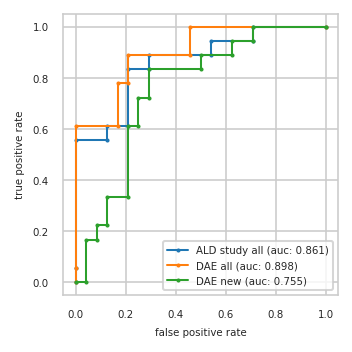

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       DAE all       DAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.000 0.056   0.000 0.056   0.042 0.000
2          0.000 0.556   0.000 0.611   0.042 0.167
3          0.125 0.556   0.167 0.611   0.083 0.167
4          0.125 0.611   0.167 0.778   0.083 0.222
5          0.208 0.611   0.208 0.778   0.125 0.222
6          0.208 0.833   0.208 0.889   0.125 0.333
7          0.292 0.833   0.458 0.889   0.208 0.333
8          0.292 0.889   0.458 1.000   0.208 0.611
9          0.542 0.889   1.000 1.000   0.250 0.611
10         0.542 0.944     NaN   NaN   0.250 0.722
11         0.708 0.944     NaN   NaN   0.292 0.722
12         0.708 1.000     NaN   NaN   0.292 0.833
13         1.000 1.000     NaN   NaN   0.500 0.833
14           NaN   NaN     NaN   NaN   0.500 0.889
15           NaN   NaN     NaN   NaN   0.625 0.889
16           NaN   NaN     NaN   NaN   0.625 0.944
17           NaN   NaN     NaN   NaN   0.708 0.944
18           NaN   NaN     NaN   NaN   0.708 1.000
19           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,DAE all,DAE new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,H3BLU2,P02766,P51688
2,O76061,P01704,P42262;P42262-2;P42262-3
3,P08670,P61981,E5RK69;E7EMC6;P08133;P08133-2
4,P61981,Q9Y2T3;Q9Y2T3-3,P31321
5,P14174,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
6,P04075,P51688,Q96GD0
7,Q9Y2T3;Q9Y2T3-3,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
8,P00338;P00338-3,P14174,A0A1W2PQ94;B4DS77;B4DS77-2;B4DS77-3


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf


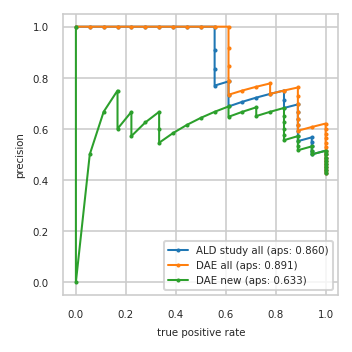

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         DAE all         DAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.500 0.944
9          0.515 0.944     0.545 1.000     0.515 0.944
10         0.531 0.944     0.562 1.000     0.531 0.944
11         0.548 0.944     0.581 1.000     0.516 0.889
12         0.567 0.944     0.600 1.000     0.533 0.889
13         0.552 0.889     0.621 1.000     0.552 0.889
14         0.571 0.889     0.607 0.944     0.571 0.889
15         0.593 0.889     0.593 0.889     0.556 0.833
16         0.615 0.889     0.615 0.889     0.577 0.833
17         0.640 0.889     0.640 0.889     0.600 0.833
18         0.667 0.889     0.667 0.889     0.625 0.833
19         0.696 0.889     0.696 0.889     0.652 0.833
20         0.682 0.833     0.727 0.889     0.682 0.833
21         0.714 0.833     0.762 0.889     0.667 0.778
22         0.750 0.833     0.750 0.833     0.650 0.722
23         0.737 0.778     0.737 0.778     0.684 0.722
24         0.722 0.722     0.778 0.778     0.667 0.667
25         0.706 0.667     0.765 0.722     0.647 0.611
26         0.688 0.611     0.750 0.667     0.688 0.611
27         0.733 0.611     0.733 0.611     0.667 0.556
28         0.786 0.611     0.786 0.611     0.643 0.500
29         0.769 0.556     0.846 0.611     0.615 0.444
30         0.833 0.556     0.917 0.611     0.583 0.389
31         0.909 0.556     1.000 0.611     0.545 0.333
32         1.000 0.556     1.000 0.556     0.600 0.333
33         1.000 0.500     1.000 0.500     0.667 0.333
34         1.000 0.444     1.000 0.444     0.625 0.278
35         1.000 0.389     1.000 0.389     0.571 0.222
36         1.000 0.333     1.000 0.333     0.667 0.222
37         1.000 0.278     1.000 0.278     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf


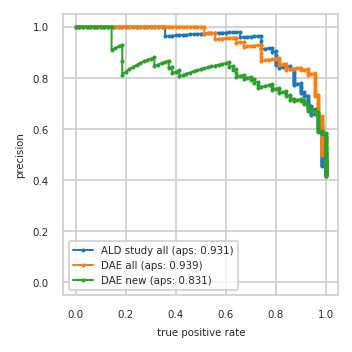

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf


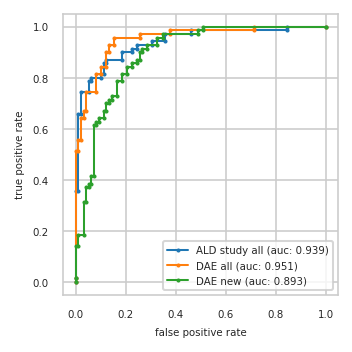

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_DAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE all.pkl'),
 'results_DAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_DAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_DAE/auc_roc_curve_train.pdf')}